In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np

# LA Metro Bike Share Data Part 1 — Linear Optimization with PuLP
본 글은 아래 Medium 링크의 글입니다.

https://towardsdatascience.com/la-metro-bike-share-data-part-1-linear-optimization-with-pulp-bc8ed4c85cd2

https://github.com/finnqiao/la_metro_bikeshare_data/blob/master/notebooks/1.0-la-bikeshare.ipynb

Python의 선형 프로그래밍을 사용하여 총 매출 극대화 가격 계획 도출

2018년도에 Bird와 Lime의 거대한 모금 행사로, 스쿠터와 자전거가 도시 이동 수단의 새로운 수단으로 등장했다.

그러나 이러한 스타트업이 등장하기 전에, 많은 도시들은 이미 자전거 공유 시스템을 정착시켰다. 그중 가장 눈에 띄는 것은 씨티바이크NYC, 디비, 캐피탈바이크셰어 등이다.

자전거 이동수단 생태계에서 훨씬 작은 주자는 2016년에 시작되어 최대 58만 개의 탑승횟수을 기록한 LA 메트로 자전거다. 이전에 30분당 3.50달러라는 비난을 받았지만, 최근 가격 구조 개편으로 화제가 되었다. 

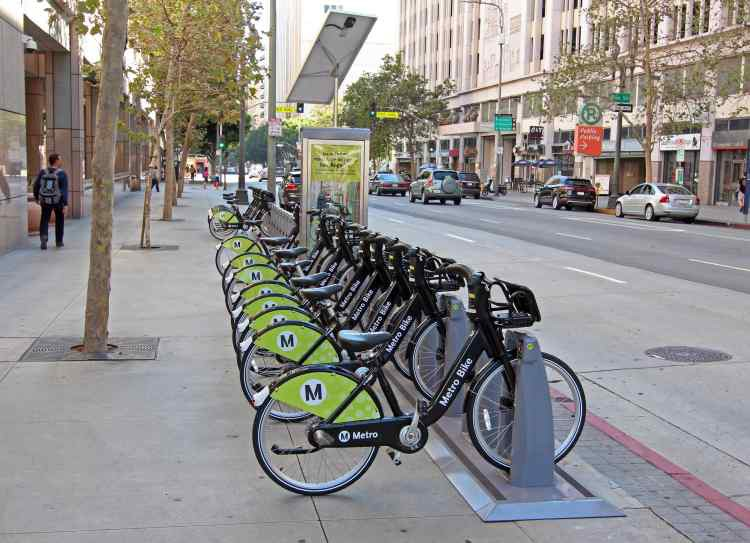

새로운 구조속에서, 가격은 30분당 1.75달러로인 절반가격으로 인하되었다. 게다가, 기간 기반 패스 역시 현재 더 저렴하다. 

이러한 가격 변화는 급격하지만, 이용 가능한 더 좋은 가격 선택권이 있을까? 파이썬의 최적화 모델로 이를 찾는데 도움이 될까?

우선, LA 메트로 데이터 사이트에서 1년치 자전거 공유 데이터를 뽑아내는 것으로 시작하자. PuLP로 최적화를 하기전에, 데이터 Cleaning 작업부터 하자.

## Data Clearning

In [ ]:
_2017Q3 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/LA Metro Bike/2017_q3.csv')
_2017Q4 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/LA Metro Bike/2017_q4.csv')
_2018Q1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/LA Metro Bike/2018_q1.csv')
_2018Q2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/LA Metro Bike/2018_q2.csv')

In [ ]:
rides_df = pd.concat([_2017Q3,_2017Q4,_2018Q1,_2018Q2])
rides_df.shape

(286295, 14)

In [ ]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,33404951,36,7/1/2017 0:09,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up
1,33404950,13,7/1/2017 0:10,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up
2,33404947,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up
3,33404948,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up
4,33404949,12,7/1/2017 0:11,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up


지난 4개의 분기동안 286000번의 탑승이 있었음. 또한 어떤 자건거가 사용 됐는지, 탑승과 하차의 지점, 탑승시간의 정보가 주어져 있음.

In [ ]:
rides_df.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_station            int64
start_lat              float64
start_lon              float64
end_station              int64
end_lat                float64
end_lon                float64
bike_id                  int64
plan_duration            int64
trip_route_category     object
passholder_type         object
dtype: object

대부분의 데이터셋과 마찬가지로, 날짜는 문자로 읽힌다.  pd.to_datetime 함수를 실행하여 start_time 및 end_time 열을 datetime 객체로 변환하자.

In [ ]:
rides_df['start_time'] = pd.to_datetime(rides_df['start_time'])
rides_df['end_time'] = pd.to_datetime(rides_df['end_time'])

우리는 데이터 프레임의 NA 값을 확인하기 위해 msno 패키지를 사용한다. 총 관측치 수에 비해 결측값 수가 거의 무시해도 될 것처럼 보이므로 행을 삭제한다.

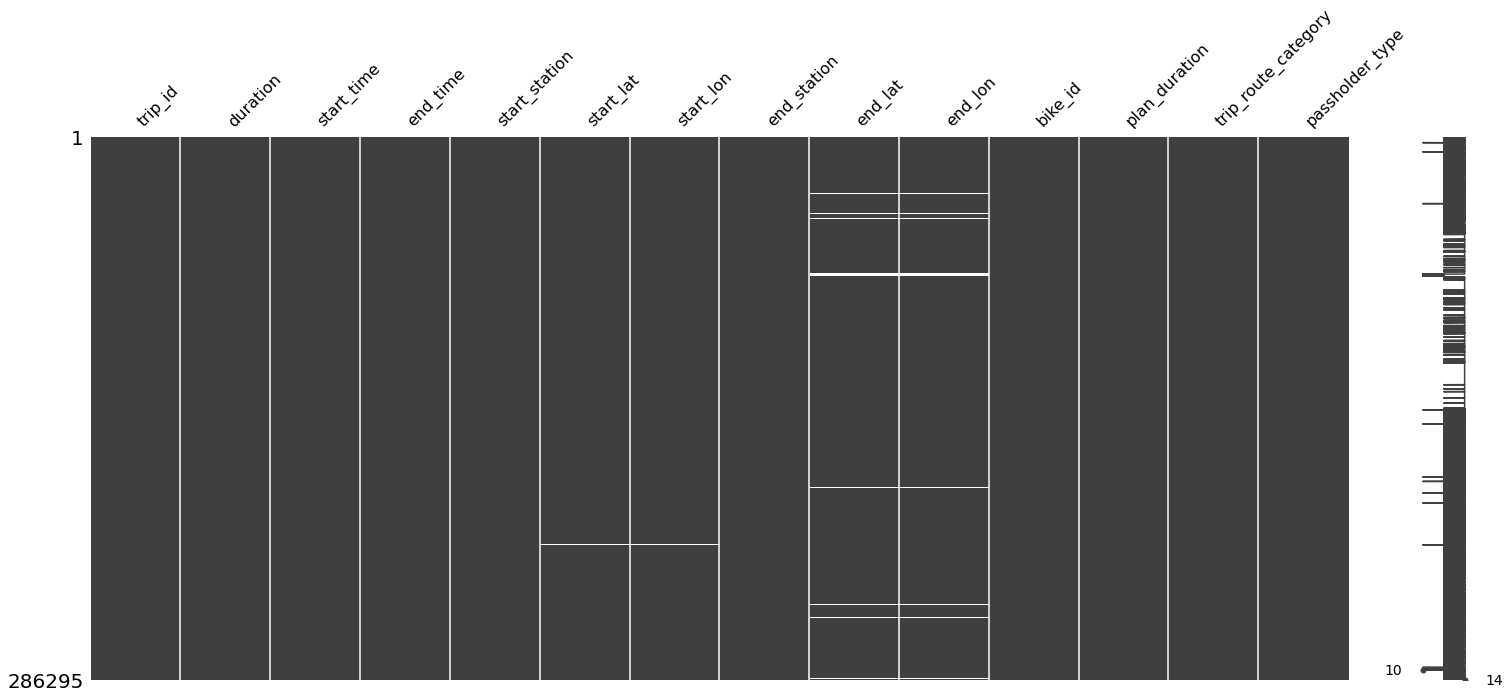

In [ ]:
# check for missing values.
%matplotlib inline
msno.matrix(rides_df)

In [ ]:
rides_df.dropna(inplace=True)

전체 행의 1.7%인 4849개 행이 삭제됐다.

## Filling in data on starting and ending bike stations

우리는 부두(docks) 수와 주소와 같은 자전거 역에 대한 더 자세한 정보가 필요하다. 이를 위해 우리는 LA 메트로에서 여러 자전거 스테이션의 주소와 용량이 포함된 json 파일을 다운로드한다.

In [ ]:
'''
json 변환코드 모르고 delete함 ㅂㄷㅂㄷ..
'''
stations_info=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/LA Metro Bike/station_df.csv')
stations_info.head()

,kiosk_id,address_street,address_zip,station_name,total_docks
0,3005,700 Flower St,90017,7th & Flower,31
1,3006,729 S Olive Street,90014,Olive & 8th,31
2,3007,557 S 5th Street,90071,5th & Grand,23
3,3008,865 S Figueroa Street,90017,Figueroa & 9th,15
4,3010,401 East 11th Street,90015,11th & Maple,22


'kiosk_id'로 rides_df와 merge가 가능함. start station과 end station을 병합하자.

In [ ]:
# Adding start station attributes.
rides_df = pd.merge(rides_df, stations_info, how = "left", left_on = 'start_station', 
               right_on = ['kiosk_id']).rename(columns = {'address_street':'start_address',
                                                          'address_zip':'start_zip','station_name':'start_name',
                                                          'total_docks':'start_docks'}).drop('kiosk_id',1)
# Adding end station attributes.
rides_df = pd.merge(rides_df, stations_info, how = "left", left_on = 'end_station', 
               right_on = ['kiosk_id']).rename(columns = {'address_street':'end_address',
                                                          'address_zip':'end_zip','station_name':'end_name',
                                                          'total_docks':'end_docks'}).drop('kiosk_id',1)

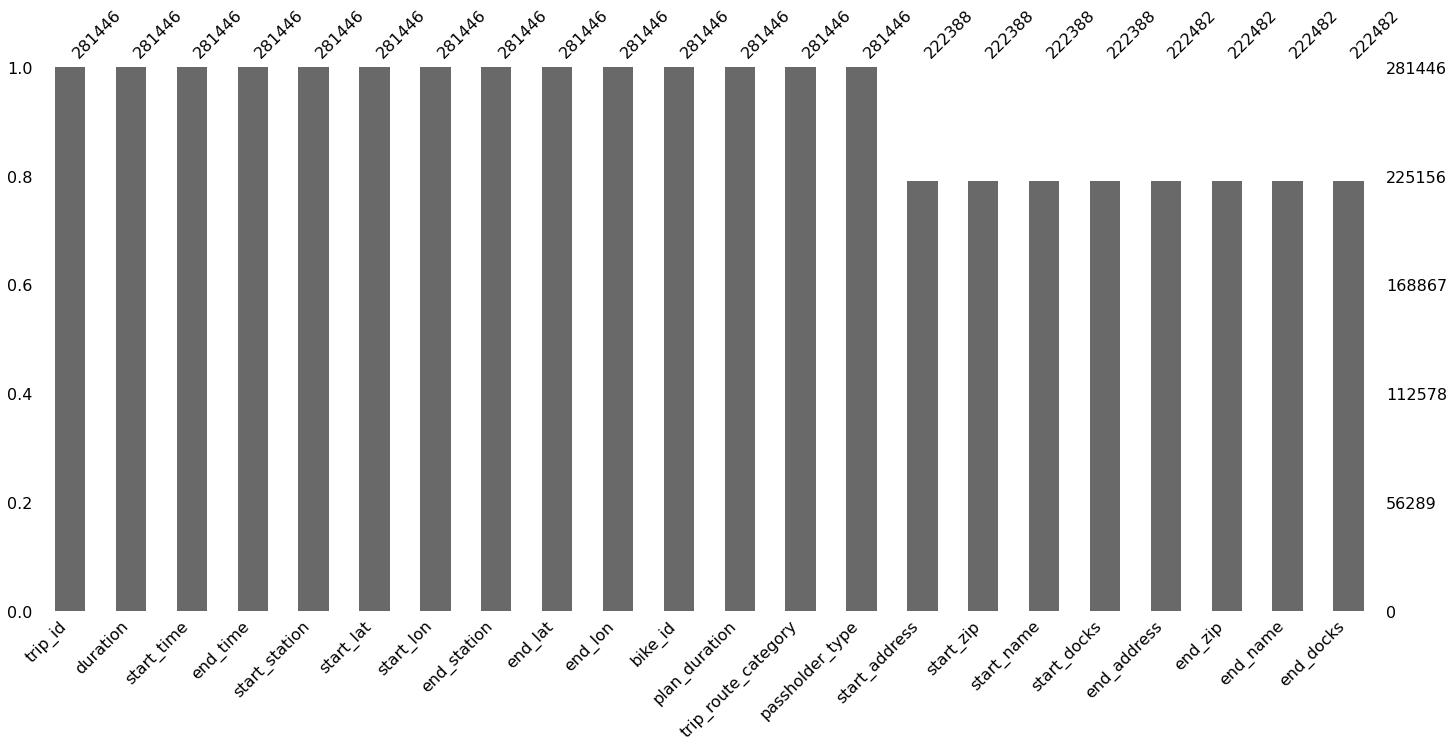

In [ ]:
msno.bar(rides_df)

NAN을 다시 한번 간단히 살펴보면, 누락된 스테이션 정보가 있는 기록이 약 20%에 이른다는 것을 알 수 있다. NA가 데이터 집합에서 상당한 부분을 차지하기 때문에 이러한 누락된 값을 어떻게 처리할 것인지 자세히 살펴보자.

스테이션에 대한 모든 정보를 채우는 것은 지루할 것이기 때문에, 스테이션의 통계치를 살펴보자.

In [ ]:
rides_df['start_station'].value_counts().describe()

count      124.000000
mean      2269.725806
std       2154.035881
min          6.000000
25%        804.500000
50%       1544.500000
75%       3019.500000
max      11437.000000
Name: start_station, dtype: float64

탑승이 가장 많은 스테이션은 11437번을 기록했고, 최소 탑승 스테이션은 6번의 탑승만 이루어졌다. 평균 2269개의 탑승이 이루어지는 스테이션만 다뤄야 할까?

중앙값 1544로 미루어 봤을 때, 2269번이라는 평균 탑승은 다소 큰 것으로 보인다. 그렇기 때문에 평균치 보다는 중앙값을 사용하자. 1544번의 탑승 이상의 스테이션만 정보를 채워주자.

In [ ]:
rides_df['start_docks'].describe()

count    222388.000000
mean         24.120168
std           5.654419
min          14.000000
25%          19.000000
50%          24.000000
75%          28.000000
max          36.000000
Name: start_docks, dtype: float64

부두(docks)의 평균값과 중앙값을 보면 합리적으로 docks의 NA를 22로 채워주는 것이 가능하다고 판단된다.

In [ ]:
# A mask is created to filter out station records that have any missing values that appear more than the
# median count aross stations
median_mask = rides_df[rides_df.isnull().any(axis = 1)]['start_station'].value_counts()\
> rides_df['start_station'].value_counts().median()

# the main dataframe is filtered by the above mask and keys are obtained. this gives us the station id's to
# fill
locations_to_fill = rides_df[rides_df.isnull().any(axis=1)]['start_station'].value_counts()[median_mask]
locations_to_fill.keys()

Int64Index([3038, 3055, 3051, 4162, 4153, 4181, 4165, 4176, 4142, 4157, 4180,
            4163, 4159, 4177],
           dtype='int64')

mask와 quick filter를 만들면서,  우리가 데이터프레임의 NA를 함께 데이터프레임을 채울 수 있는 스테이션의 list를 얻었다.

수기 검색과 구글 API를 혼용하여 일부 누락된 스테이션에 대해 다음과 같은 정보를 얻는다.

In [ ]:
lats = []
longs = []
for station_id in locations_to_fill.keys():
    lats.append(rides_df['start_lat'][rides_df['start_station'] == station_id].iloc[0])
    longs.append(rides_df['start_lon'][rides_df['start_station'] == station_id].iloc[0])

In [ ]:
manual_add_cols = list(stations_info.columns)
manual_add_cols.extend(('start_lat','start_lon'))
manual_add_cols[0] = 'start_station'
manual_kiosk_add = pd.DataFrame(columns = manual_add_cols)
manual_kiosk_add['start_station'] = np.asarray(locations_to_fill.keys())
manual_kiosk_add['end_station'] = manual_kiosk_add['start_station']
manual_kiosk_add['start_lat'] = np.asarray(lats)
manual_kiosk_add['start_lon'] = np.asarray(longs)
manual_kiosk_add

,start_station,address_street,address_zip,station_name,total_docks,start_lat,start_lon,end_station
0,3038,NaN,NaN,NaN,NaN,34.046822,-118.248352,3038
1,3055,NaN,NaN,NaN,NaN,34.044159,-118.251579,3055
2,3051,NaN,NaN,NaN,NaN,34.045422,-118.253517,3051
3,4162,NaN,NaN,NaN,NaN,34.147499,-118.148010,4162
4,4153,NaN,NaN,NaN,NaN,34.156181,-118.166687,4153
5,4181,NaN,NaN,NaN,NaN,34.146221,-118.135262,4181
6,4165,NaN,NaN,NaN,NaN,34.141750,-118.149063,4165
7,4176,NaN,NaN,NaN,NaN,34.137859,-118.122414,4176
8,4142,NaN,NaN,NaN,NaN,34.144588,-118.144592,4142
9,4157,NaN,NaN,NaN,NaN,34.140999,-118.132088,4157


In [ ]:
manual_street_addresses = []
manual_zips = []
manual_names = []
manual_street_addresses.extend(('447-499 S Main St','111 W 7th St r5','309 7th St','136 E Holly St','1001 Rose Bowl Dr','2-26 N Oak Knoll Ave','272-260 S Raymond Ave', '1320-1342 San Pasqual St', '300 E Green St', '270 S Lake Ave', '1085-1041 San Pasqual St', '300 N Lake Ave','1570 E Colorado Blvd','50 S Madison Ave'))
manual_zips.extend((90013,90014,90014,91103, 91103, 91101, 91105, 91106, 91101, 91101, 91106, 91101, 91106, 91101))
manual_names.extend(('Lokal sandwich shop','SB Main','Metro Bike Share - 7th & Broadway','Memorial Park Station', 'Rose Bowl Stadium', 'E Colorado Blvd Target','Central Park','Caltech Student Services','Pasadena Civic Auditorium', 'The Shops on Lake Avenue','Caltech Graduate Housing', 'Gateway Plaza', 'Pasadena City College Shatford Library', 'Playhouse parking lot'))

In [ ]:
manual_kiosk_add['address_street'] = np.asarray(manual_street_addresses)
manual_kiosk_add['address_zip'] = np.asarray(manual_zips)
manual_kiosk_add['station_name'] = np.asarray(manual_names)
manual_kiosk_add = manual_kiosk_add.fillna(22)

manual_kiosk_add

,start_station,address_street,address_zip,station_name,total_docks,start_lat,start_lon,end_station
0,3038,447-499 S Main St,90013,Lokal sandwich shop,22,34.046822,-118.248352,3038
1,3055,111 W 7th St r5,90014,SB Main,22,34.044159,-118.251579,3055
2,3051,309 7th St,90014,Metro Bike Share - 7th & Broadway,22,34.045422,-118.253517,3051
3,4162,136 E Holly St,91103,Memorial Park Station,22,34.147499,-118.148010,4162
4,4153,1001 Rose Bowl Dr,91103,Rose Bowl Stadium,22,34.156181,-118.166687,4153
5,4181,2-26 N Oak Knoll Ave,91101,E Colorado Blvd Target,22,34.146221,-118.135262,4181
6,4165,272-260 S Raymond Ave,91105,Central Park,22,34.141750,-118.149063,4165
7,4176,1320-1342 San Pasqual St,91106,Caltech Student Services,22,34.137859,-118.122414,4176
8,4142,300 E Green St,91101,Pasadena Civic Auditorium,22,34.144588,-118.144592,4142
9,4157,270 S Lake Ave,91101,The Shops on Lake Avenue,22,34.140999,-118.132088,4157


In [ ]:
# Function to use the df. where function to map vlaues to original dataframe
def fill_df_null(df1,df2, target_col,common_col,alt_name):
  df1[target_col] = df1[target_col].where(df1[target_col].notnull(),
                                          df1[common_col].map(df2.set_index(common_col)[alt_name]))

fill_df_null(rides_df, manual_kiosk_add, 'start_address', 'start_station', 'address_street')
fill_df_null(rides_df, manual_kiosk_add, 'start_zip', 'start_station', 'address_zip')
fill_df_null(rides_df, manual_kiosk_add, 'start_name', 'start_station', 'station_name')
fill_df_null(rides_df, manual_kiosk_add, 'start_docks', 'start_station', 'total_docks')

fill_df_null(rides_df, manual_kiosk_add, 'end_address', 'end_station', 'address_street')
fill_df_null(rides_df, manual_kiosk_add, 'end_zip', 'end_station', 'address_zip')
fill_df_null(rides_df, manual_kiosk_add, 'end_name', 'end_station', 'station_name')
fill_df_null(rides_df, manual_kiosk_add, 'end_docks', 'end_station', 'total_docks')

where,map 메서드를 활용한 데이터프레임의 결측치를 채우는 방법은 상당히 유용한 것 같으니까 기억해 두자.

https://github.com/DrumDong/Python_Book/blob/master/Pandas/Pandas_where.ipynb


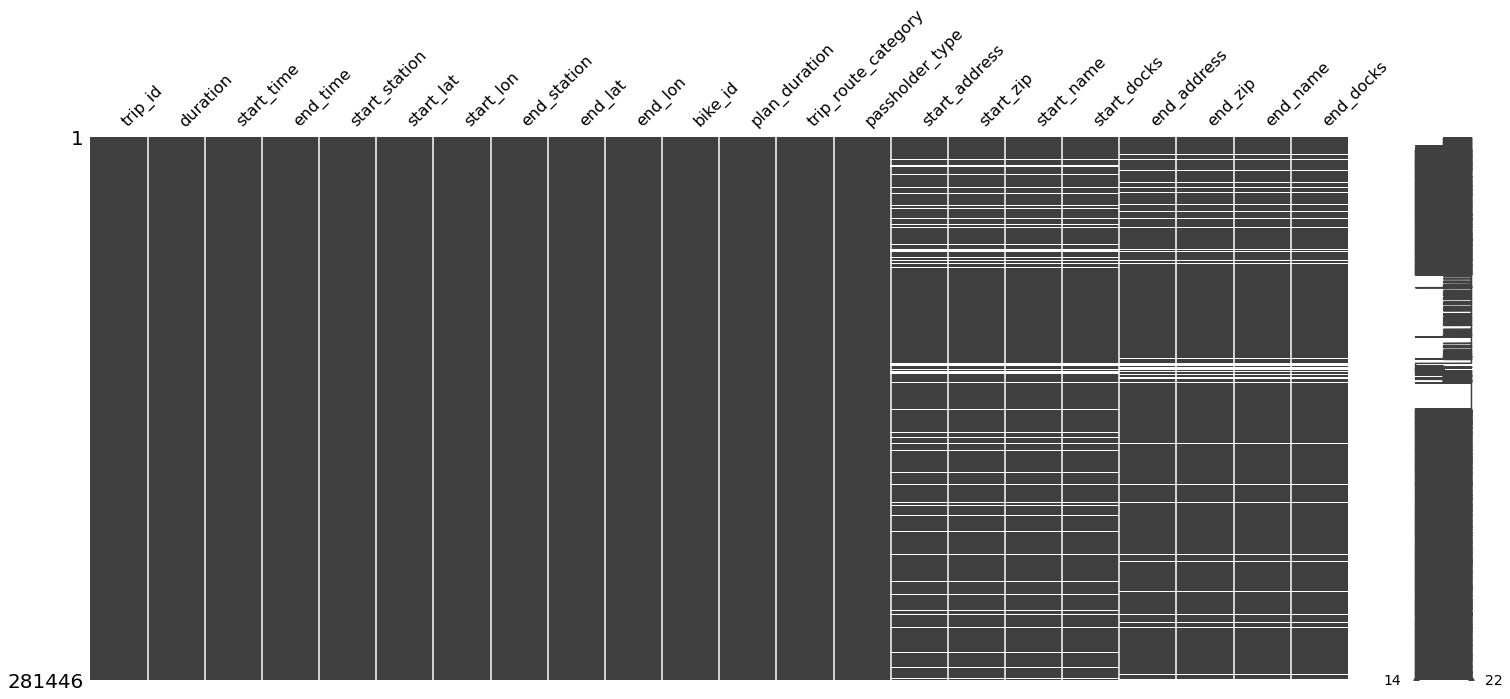

In [ ]:
msno.matrix(rides_df)

In [ ]:
rides_df = rides_df.dropna()

In [ ]:
rides_df.shape

(245010, 22)

## Futher feature engineering

In [ ]:
# 가격 정책에 맞게 label 부여
def label_charged(duration):
  if duration <=30:
    return 0
  else:
    return 1

rides_df['charged_ride'] = rides_df['duration'].apply(label_charged)

In [ ]:
# 탑승 시간(hour) 컬럼
rides_df['start_hour'] = rides_df['start_time'].dt.hour

In [ ]:
latest_ride_date = rides_df['end_time'].max()
latest_ride_date

Timestamp('2018-07-02 00:09:00')

In [ ]:
bike_last_used_id = rides_df.groupby('bike_id')['end_time'].max().keys().tolist()
bike_last_used_date = rides_df.groupby('bike_id')['end_time'].max().to_list()

### Active bikes
또 다른 주목할 만한 주제는 LA 메트로 자전거의 이용이었다.

In [ ]:
# 한 해 동안 매월 활성 상태인 자전거 수
for month in range(1,13):
  print(month, len([record for record in list(zip(bike_last_used_id,bike_last_used_date)) if
                    record[1]> latest_ride_date + np.timedelta64(-month,'M')]))

1 1171
2 1255
3 1288
4 1312
5 1317
6 1322
7 1329
8 1337
9 1343
10 1346
11 1349
12 1353


In [ ]:
# 최근 6개월동안 사용되지 않은 자전거의 수
len([record for record in list(zip(bike_last_used_id,bike_last_used_date)) if 
     record[1] < latest_ride_date + np.timedelta64(-6, 'M') ])

31

지난 6개월동안 사용된 자전거와 그렇지 않은 자전거를 나눠주는 Binary 변수를 생성해 주자.

In [ ]:
# 지난 6개월 동안 사용된 자전거는 1, 아닐 경우는 0
inactive_ids = [record[0] for record in list(zip(bike_last_used_id,bike_last_used_date)) if 
                record[1] < latest_ride_date + np.timedelta64(-6, 'M') ]
rides_df['active_6m'] = rides_df['bike_id'].apply(lambda bike_id: 0 if bike_id in (inactive_ids) else 1)

### Dummy variables
범주형 데이터도 따로 처리해 주자.

In [ ]:
# 더비 변수 unique 값
rides_df['passholder_type'].unique()

array(['Walk-up', 'Monthly Pass', 'Flex Pass', 'One Day Pass'],
      dtype=object)

In [ ]:
# passholder_type
one_hot_pass = pd.get_dummies(rides_df['passholder_type']).rename(columns={
    'Flex Pass' : 'annual',
    'Monthly Pass' : 'monthly',
    'One Day Pass' : 'one_day',
    'Walk-up' : 'walk_up'
})

# trip_route_category
one_hot_trip_type = pd.get_dummies(rides_df['trip_route_category']).rename(columns = {
    'One Way' : 'one_way',
    'Round Trip' : 'round_trip'
})

rides_df = rides_df.join([one_hot_pass, one_hot_trip_type])

어느정도 전처리 작업이 완료됐으니 최적화를 진행해 보자.

## Pricing plan optimization


### 목적과 제약 정의
이 최적화의 목표는 LA 메트로 자전거의 총 수익을 극대화하는 것이다. 이러한 선형 최적화를 위해 PuLP 라이브러리를 활용할 것이다.

두가지 주요 수익원
- 모든 탑승의 요금 합계
- 총 탑승권 판매량(일간,월간,연간)

LA 메트로는 가격 구조를 변경하거나 요금제를 변경하여 총 수익을 늘릴 수 있다.

LA 메트로 바이크는 최근 다음과 같은 새로운 가격 구조를 구현했다. 종전의 계획과 현재의 계획은 다음과 같다.


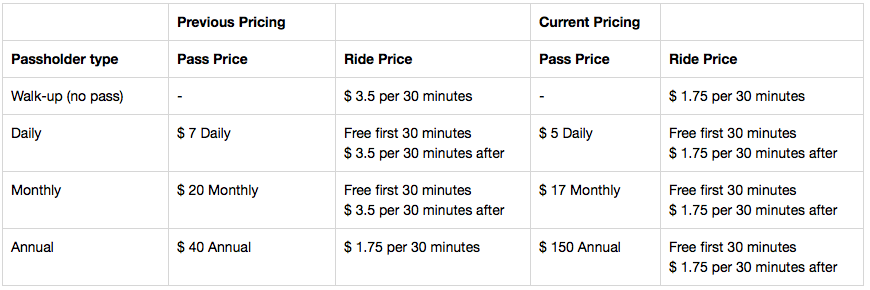

#### Current pricing
Walk up
$ 1.75 for each 30 min trip   
$ 1.75 per 30 minutes thereafter

Day Pass $5/day All rides 30 minutes or less are free $1.75 per 30 minutes thereafter

Sign Up Monthly Pass $17/month All rides 30 minutes or less are free $1.75 per 30 minutes thereafter

Sign Up Annual Pass $150/year Equivalent to $12.50/month All rides 30 minutes or less are free $1.75 per 30 minutes thereafter

####Previous pricing
Walk-up $3.50/30 minutes All trips 30 minutes or less are $3.50 $3.50 per 30 minutes thereafter

Find a Station One Day Pass $7/day All trips 30 minutes or less are free $1.75 per 30 minutes thereafter

Buy a Pass Monthly Pass $20/month All trips 30 minutes or less are free $1.75 per 30 minutes thereafter

Buy a Pass Annual Pass/Flex Pass $40/year $1.75 per 30 minutes

#### Competitor pricing:
Bird Scooters - $.15 per minute

Lime Pedal Bikes - $1 to unlock + $0.05/minute to ride.

Lime-E Electric Assist Bikes - $1 to unlock +  $.15 per minute

Lime-S Electric Scooters - $1 to unlock + $.15 per minute

LimePrime - $29.95 per month and includes $100 in ride credits for use on Lime Classic Pedal Bikes only.

LimePrime Students is $14.95 per month and includes 100 ride credits, with a valid ".EDU" email address. Students, faculty and staff all qualify.

JUMP Bikes (& scooters) (Santa Monica only) - $1 for first 5 minutes + $.15 per minute after

JUMP Bikes (& scooters) Boost Plan (Santa Monica only) - $5 a month for 60 minutes a day of ride time + .07 after 60 min.

##Optimization models
경쟁자들로부터 보여지듯이, 가격 결정 체계가 구성될 수 있는 방법은 여러 가지가 있다. 구현 및 비교할 수 있는 몇 가지 옵션은 다음과 같다.
1. 분당 변동률
2. 시간 간격별 변동 속도(현재 LA 메트로의 경우 30분)
3. 모든 탑승에 대한 고정 요금
4. 변동요금을 구현하기 전의 시간 간격에 대한 고정수수료
5. 모든 자전거를 특정 기간까지 이용할 수 있는 주간, 월간 통행권. 이후 변동률


현재 LA 메트로별 모델과 현재 고객 세분화 수준이 필요한지 검토하자. 다른 회사의 자전거 및 스쿠터와 비교하여 가격을 벤치마킹하기 위해, 모든 회사에 대해 서로 다른 가격 곡선을 그려보자.

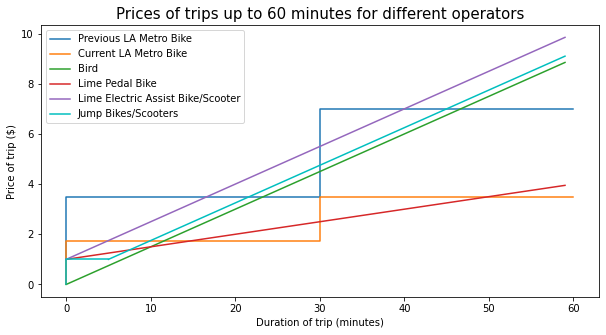

In [33]:
fig, axes = plt.subplots(figsize=(10,5))
x = np.array(range(0,60))
prev_la, = plt.step([0,30,60], [0,3.5,7], label = 'Previous LA Metro Bike')
cur_la, = plt.step([0,30,60], [0,1.75,3.5], label = 'Current LA Metro Bike')
bird, = plt.plot(x, 0.15 * x, label = 'Bird')
lime_ped, = plt.plot(x, 1 + 0.05 * x, label = 'Lime Pedal Bike')
lime_scoot, = plt.plot(x, 1 + 0.15 * x, label = 'Lime Electric Assist Bike/Scooter')
jump1, = plt.step([0,5],[0,1],label = 'Jump Bikes/Scooters',color = 'c')
jump2, = plt.plot(np.array(range(5,60)), 0.15 * np.array(range(5,60)) + 0.25, color = 'c')
plt.title('Prices of trips up to 60 minutes for different operators', size=15)
plt.xlabel('Duration of trip (minutes)')
plt.ylabel('Price of trip ($)')
plt.legend()
plt.show()